## Code for binary class fusion model-1 (ANN+RF) using weighted score fusion

In [4]:
%pip install tensorflow


In [5]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense ,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

In [6]:
dataset = pd.read_csv("/content/sample_data/binary classification.csv", delimiter=",")
dataset_array = dataset.to_numpy()
x = dataset_array[:, 0:13]
y = dataset_array[:, 13]

In [7]:
#for 80:20 ratio
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

#for 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)


In [8]:

#StandardScaler for normalization for some algortihms
sc = StandardScaler()

#min-max scaler for normalization for some algortihms
scaler = MinMaxScaler(feature_range=(0,1))




Information based algorithms (Decision Trees, Random Forests) and probability based algorithms (Naive Bayes, Bayesian Networks) don't require normalization either.

In [9]:
#code for RF

from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(n_estimators=100)

model3.fit(X_train,y_train)
rounded_predictions3 = model3.predict(X_test)
predictions3 =model3.predict_proba(X_test)
y_pred3 = rounded_predictions3


import sklearn.metrics as metrics
scores3=metrics.accuracy_score(y_test,y_pred3)
print("RF",scores3)

print(metrics.confusion_matrix(y_test,y_pred3))
print(metrics.classification_report(y_test,y_pred3))


fpr3, tpr3, threshold = metrics.roc_curve(y_test, y_pred3)
roc_auc3 = metrics.auc(fpr3, tpr3)
print("roc_auc_RF",roc_auc3)


#code for ANN

from keras import regularizers
from keras.regularizers import l2



scaled_X_train_ann=scaler.fit_transform(X_train)
scaled_X_test_ann=scaler.transform(X_test)



model2 = Sequential()
model2.add(Dense(8, input_dim=13,activation='relu',kernel_regularizer=l2(0.01) ))
model2.add(Dense(1, activation='sigmoid'))
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])

history=model2.fit(scaled_X_train_ann, y_train,validation_split=0.1, batch_size=10,epochs=15,shuffle=True,verbose=2)


predictions2 = model2.predict(scaled_X_test_ann,batch_size=5,verbose=0)
#rounded_predictions2 = model2.predict_classes(scaled_X_test_ann,batch_size=5,verbose=0)
rounded_predictions2=np.round(predictions2).astype(int)
y_pred2 = rounded_predictions2

import sklearn.metrics as metrics
score2=metrics.accuracy_score(y_test,y_pred2)
print("ANN",score2)

print(metrics.confusion_matrix(y_test,y_pred2))
print(metrics.classification_report(y_test,y_pred2))

fpr2, tpr2, threshold = metrics.roc_curve(y_test,y_pred2)
roc_auc2 = metrics.auc(fpr2, tpr2)
print("roc_auc_ann",roc_auc2)



RF 0.8131868131868132
[[42 11]
 [ 6 32]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83        53
         1.0       0.74      0.84      0.79        38

    accuracy                           0.81        91
   macro avg       0.81      0.82      0.81        91
weighted avg       0.82      0.81      0.81        91

roc_auc_RF 0.817279046673287
Epoch 1/15
19/19 - 2s - loss: 0.8570 - accuracy: 0.4737 - val_loss: 0.7287 - val_accuracy: 0.6364 - 2s/epoch - 110ms/step
Epoch 2/15
19/19 - 0s - loss: 0.8382 - accuracy: 0.4421 - val_loss: 0.7299 - val_accuracy: 0.7273 - 106ms/epoch - 6ms/step
Epoch 3/15
19/19 - 0s - loss: 0.8237 - accuracy: 0.4579 - val_loss: 0.7307 - val_accuracy: 0.7273 - 109ms/epoch - 6ms/step
Epoch 4/15
19/19 - 0s - loss: 0.8117 - accuracy: 0.4842 - val_loss: 0.7299 - val_accuracy: 0.6818 - 247ms/epoch - 13ms/step
Epoch 5/15
19/19 - 0s - loss: 0.8016 - accuracy: 0.5316 - val_loss: 0.7259 - val_accuracy: 0.6818 - 142ms/epoch

In [10]:
#weighted fusion
#same procedure for every model(1,2 and 3). for every model we need to take the prediction
# values and then the values will be merged according to the procedure given in below.

#selecting the best value for p and q(p & q represents the weights w1 & w2)
p=1
#q=1-p
for i in range (19):
    p=p-.05
    q=1-p


    mixed=predictions3[:,1]*p+predictions2[:,0]*q
    rounded_mixed=mixed
    for i in range(len(y_test)):
        if mixed[i]>.5:
            rounded_mixed[i]=1
        else:
            rounded_mixed[i]=0

    score=metrics.accuracy_score(rounded_mixed,y_test)
    print("  mixed  p  q","%.4f" %score, "%.2f" %p,"%.2f" %q)


#after selecting the value of p and q which gives the highest accuracy. This value differs for different algorithms.

p=.05
q=1-p

mixed=predictions3[:,1]*p+predictions2[:,0]*q
rounded_mixed=mixed
for i in range(len(y_test)):
    if mixed[i]>=.5:
        rounded_mixed[i]=1
    else:
         rounded_mixed[i]=0

score=metrics.accuracy_score(rounded_mixed,y_test)
print("mixed",score)

print(metrics.confusion_matrix(y_test,rounded_mixed))
print(metrics.classification_report(y_test,rounded_mixed))

fpr, tpr, threshold = metrics.roc_curve(rounded_mixed,y_test)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc_tot",roc_auc)




  mixed  p  q 0.8022 0.95 0.05
  mixed  p  q 0.8132 0.90 0.10
  mixed  p  q 0.8352 0.85 0.15
  mixed  p  q 0.8242 0.80 0.20
  mixed  p  q 0.8132 0.75 0.25
  mixed  p  q 0.8022 0.70 0.30
  mixed  p  q 0.8132 0.65 0.35
  mixed  p  q 0.8132 0.60 0.40
  mixed  p  q 0.8132 0.55 0.45
  mixed  p  q 0.8022 0.50 0.50
  mixed  p  q 0.8242 0.45 0.55
  mixed  p  q 0.8571 0.40 0.60
  mixed  p  q 0.8571 0.35 0.65
  mixed  p  q 0.8462 0.30 0.70
  mixed  p  q 0.8462 0.25 0.75
  mixed  p  q 0.8352 0.20 0.80
  mixed  p  q 0.8242 0.15 0.85
  mixed  p  q 0.8132 0.10 0.90
  mixed  p  q 0.8132 0.05 0.95
mixed 0.8131868131868132
[[49  4]
 [13 25]]
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        53
         1.0       0.86      0.66      0.75        38

    accuracy                           0.81        91
   macro avg       0.83      0.79      0.80        91
weighted avg       0.82      0.81      0.81        91

roc_auc_tot 0.8261957730812013


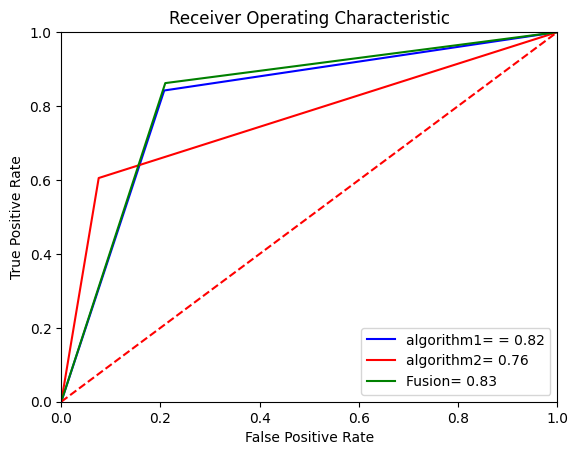

In [11]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr3, tpr3, 'b', label = 'algorithm1= = %0.2f' % roc_auc3)
plt.plot(fpr2, tpr2, 'r', label = 'algorithm2= %0.2f' % roc_auc2)
plt.plot(fpr, tpr, 'g', label = 'Fusion= %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

